# $G^2$ only model

This notebook constructs an optimal model for predicting $\text{TiO}_2$ energies for $G^2$ and $G^4$ symmetry functions.

# Featurization

In [1]:
from dscribe.descriptors import ACSF
import numpy as np

# radius cutoff, using 6 Angstroms as Behler does
r_cut = 6.0
R_s = np.linspace(0.0, r_cut, 12)
sigma = np.linspace(0.5, r_cut, 12)
eta = 1 / (2 * sigma**2)
g2_params = [[e, rs] for e in eta for rs in R_s]

species = ["Ti", "O"]
acsf = ACSF(
    species=species,
    r_cut=6.0,
    g2_params=g2_params,
    periodic=True
)


# Reading in the data

Data retrieved from [N. Artrith and A. Urban, Comput. Mater. Sci. 114 (2016) 135-150.](http://ann.atomistic.net/download/)

In [2]:
import os
from ase.io import read


# energy/atom
def read_xsf_all(directory):
    data = []

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.xsf'):
            path = os.path.join(directory, filename)

            atoms = read(path)

            with open(path, 'r') as f:
                for line in f:
                    if line.strip().startswith('# total energy'):
                        energy = float(line.strip().split('=')[1].split()[0])
                        break
                else:
                    raise ValueError(f"No energy found in {filename}")

            energy_per_atom = energy / len(atoms)
            data.append((atoms, energy_per_atom))

    return data


Uncomment this next block to generate features for the first time. Subsequently, comment it so that it does not recalculate features every time.

In [3]:
from joblib import Parallel, delayed, dump
from tqdm import tqdm


# Uncomment to overwrite current features. Note that this may take some time, so it is best to reuse already generated features.
# data = read_xsf_all('310 Final Project/data/data-set-2016-TiO2/')

# # Extract Atoms objects and energies
# atoms_list = [atoms for atoms, energy in data]
# energies = np.array([energy for atoms, energy in data])

# # Define featurization function (note: no n_jobs inside acsf.create)
# def featurize(atoms):
#     return acsf.create(atoms).mean(axis=0)  # Average over atoms per structure

# # Featurize in parallel
# print("Featurizing structures with joblib...")
# features = Parallel(n_jobs=-1)(
#     delayed(featurize)(atoms) for atoms in tqdm(atoms_list)
# )
# features = np.array(features)

# # Confirm shape
# print(f"Featurized shape: {features.shape}, Energies shape: {energies.shape}")

In [4]:
data = np.load("acsf_features_tio2_per_atom_g2.npz")
X = data["X"]
y = data["y"]

# Feature Preprocessing
Features are split into training and test sets, and normalized by a RobustScaler (to handle outliers).

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
import joblib

# Split before scaling to avoid data leakage
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale X using RobustScaler
x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_val_scaled = x_scaler.transform(X_val)

# Scale y using RobustScaler
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).ravel()

joblib.dump(x_scaler, 'X_scaler_g2.save')
joblib.dump(y_scaler, 'y_scaler_g2.save')


['y_scaler_g2.save']

# First Hyperparameter Optimization

In [6]:
import numpy as np
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Model Builder 
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', 64, 512, step=64),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))

    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', 32, 512, step=32),
            activation='relu'
        ))
        model.add(Dropout(rate=hp.Float('dropout', 0.0, 0.5, step=0.05)))

    model.add(Dense(1))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop', 'adamax'])
    optimizers = {
        'adam': Adam(),
        'rmsprop': RMSprop(),
        'sgd': SGD(),
        'adamax': Adamax()
    }

    model.compile(
        optimizer=optimizers[optimizer_name],
        loss=Huber(),
        metrics=['mae'],
    )

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Hyperparameter Search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=5,
    directory='acsf_simple_tuning',
    project_name='g2_tuning',
    overwrite=False  # set to True if you want to clear previous runs
)

tuner.search(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the best model on the test set
best_model = tuner.get_best_models(1)[0]
val_loss, val_mae = best_model.evaluate(X_val, y_val, verbose=0)
print(f"Best model — Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")


Reloading Tuner from acsf_simple_tuning/g2_tuning/tuner0.json


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-21 22:43:16.344000: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-21 22:43:16.344026: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-21 22:43:16.344039: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1745300596.344058 2791838 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745300596.344085 2791838 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physica

Best model — Val Loss: 849.5099, Val MAE: 850.0099


In [7]:
# Save the best model to disk
best_model.save('best_acsf_model_g2.h5')

# Print the best hyperparameters
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

best_model.summary()

# Predict on the test set
y_pred_scaled = best_model.predict(X_val_scaled).ravel()


{'units_input': 64, 'num_layers': 1, 'units_0': 256, 'dropout': 0.15000000000000002, 'optimizer': 'adamax', 'units_1': 352, 'units_2': 512}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,521 (138.75 KB)

 Trainable params: 35,521 (138.75 KB)

 Non-trainable params: 0 (0.00 B)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


The samples are unscaled to be evaluated:

In [8]:
from sklearn.preprocessing import RobustScaler

y_val_unscaled = y_val.reshape(-1, 1)
y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_val_unscaled = y_scaler.inverse_transform(y_val_unscaled).ravel()


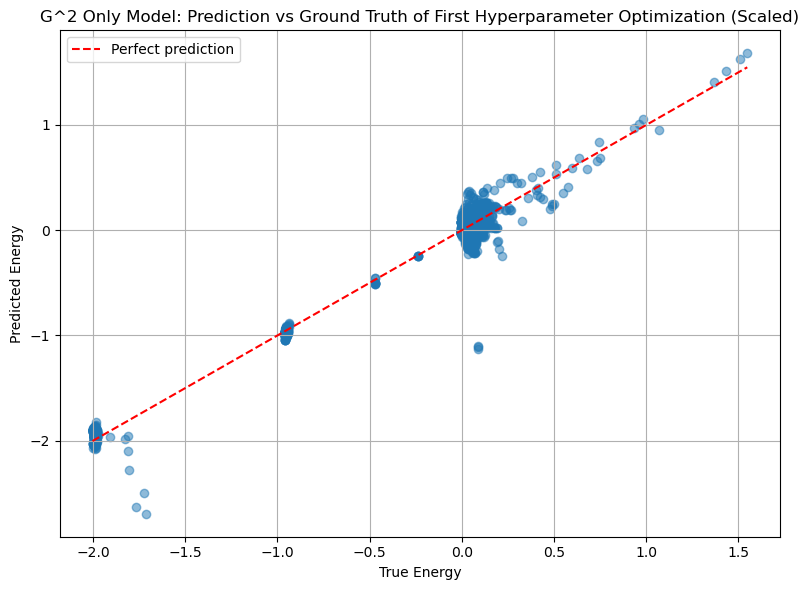

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_val_scaled, y_pred_scaled, alpha=0.5)
plt.plot([min(y_val_scaled), max(y_val_scaled)],
         [min(y_val_scaled), max(y_val_scaled)],
         'r--', label='Perfect prediction')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('G^2 Only Model: Prediction vs Ground Truth of First Hyperparameter Optimization (Scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hp)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


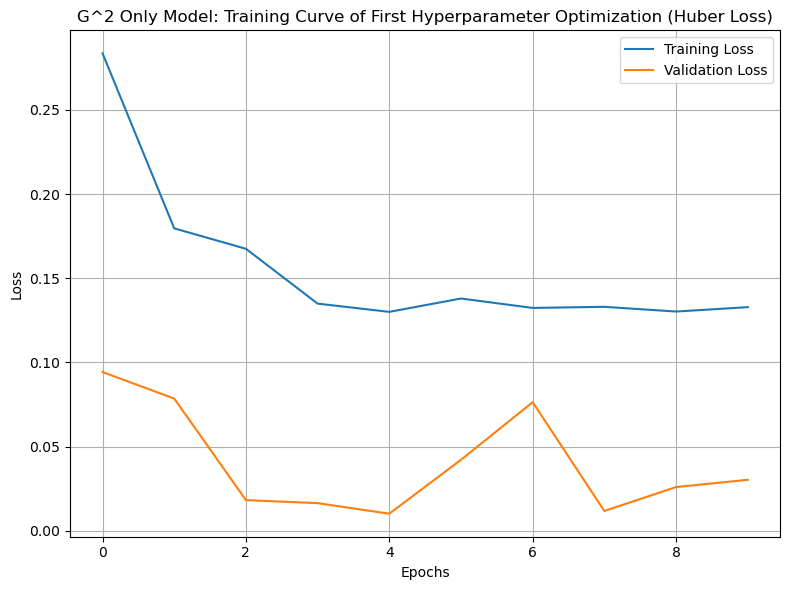

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('G^2 Only Model: Training Curve of First Hyperparameter Optimization (Huber Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Second Hyperparameter Optimization (Narrowed range)


In [12]:
import numpy as np
from keras_tuner import RandomSearch
from keras_tuner.engine import trial as trial_module
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Custom Tuner with Tunable Batch Size

class BatchSizeTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Sample batch size from the hyperparameter space
        batch_size = trial.hyperparameters.Int('batch_size', 16, 128, step=16)
        kwargs['batch_size'] = batch_size

        # Actually run the trial
        return super().run_trial(trial, *args, **kwargs)


# Model builder
def build_model(hp):
    activation = hp.Choice('activation', ['relu', 'elu'])
    use_batch_norm = hp.Boolean('use_batch_norm')
    dropout_rate = hp.Float('dropout', 0.1, 0.4, step=0.05)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(
        units=hp.Int('units_input', 64, 384, step=64),
        activation=activation
    )(inputs)

    if use_batch_norm:
        x = BatchNormalization()(x)

    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(
            units=hp.Int(f'units_{i}', 128, 768, step=128),
            activation=activation
        )(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(rate=dropout_rate)(x)

    if hp.Boolean('final_dropout'):
        x = Dropout(rate=hp.Float('final_dropout_rate', 0.05, 0.3, step=0.05))(x)

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adamax(learning_rate=learning_rate),
        loss=Huber(),
        metrics=['mae']
    )
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# Hyperparameter search
tuner = BatchSizeTuner(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=5,
    directory='acsf_simple_tuning_narrowed_G2',
    project_name='expanded_tuning',
    overwrite=False
)

tuner.search(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=40,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate best model
best_model = tuner.get_best_models(1)[0]
val_loss, val_mae = best_model.evaluate(X_val_scaled, y_val_scaled, verbose=0)
print(f"Best model — Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")


Reloading Tuner from acsf_simple_tuning_narrowed_G2/expanded_tuning/tuner0.json


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model — Val Loss: 0.0006, Val MAE: 0.0216


In [13]:
# Save the best model to disk
best_model.save('best_acsf_model_g2_OPTIMAL.h5')

In [14]:
y_pred_scaled = best_model.predict(X_val_scaled).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = y_val  # Already unscaled
mae = np.mean(np.abs(y_pred - y_true))
print(f"MAE in eV/atom: {mae:.4f}")
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
print(f"RMSE in eV/atom: {rmse:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
MAE in eV/atom: 0.3825
RMSE in eV/atom: 0.6222


In [15]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hp)

early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-6)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=150,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


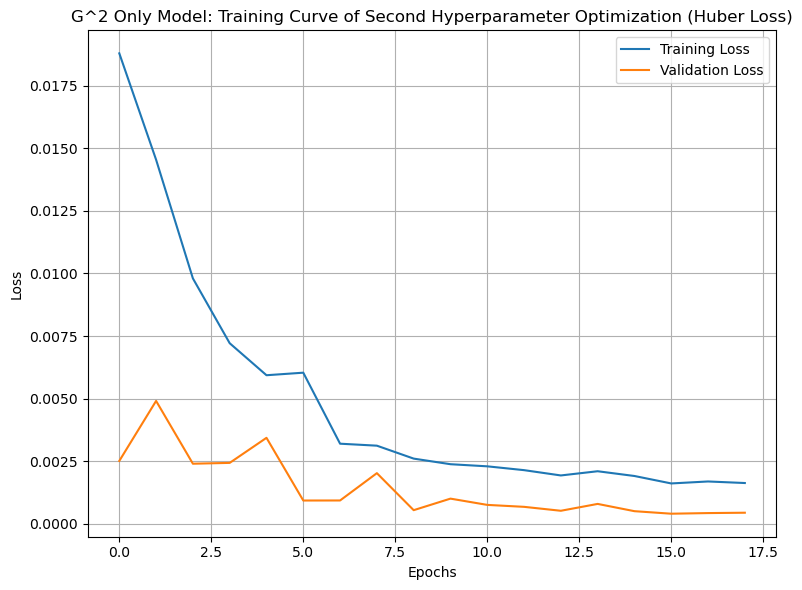

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('G^2 Only Model: Training Curve of Second Hyperparameter Optimization (Huber Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


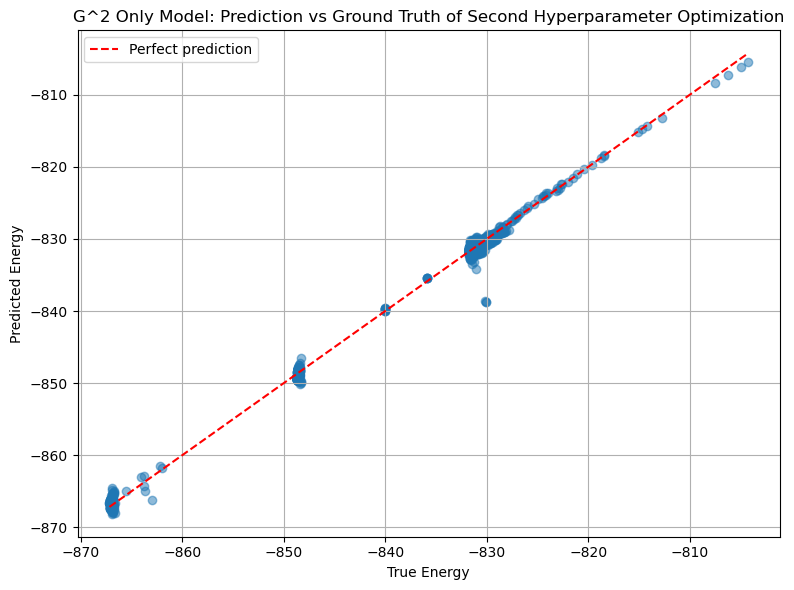

In [17]:
y_pred_scaled = best_model.predict(X_val_scaled).ravel()
y_val_unscaled = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).ravel()
y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(8, 6))
plt.scatter(y_val_unscaled, y_pred_unscaled, alpha=0.5)
plt.plot([min(y_val_unscaled), max(y_val_unscaled)],
         [min(y_val_unscaled), max(y_val_unscaled)],
         'r--', label='Perfect prediction')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('G^2 Only Model: Prediction vs Ground Truth of Second Hyperparameter Optimization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Root Mean Square Error (RMSE) and Mean Absolute Error (MAE)

In [18]:
print("RMSE: ", np.sqrt(np.mean((y_val_unscaled - y_pred_unscaled) ** 2)))
print("MAE: ", np.mean(np.abs(y_val_unscaled - y_pred_unscaled)))


RMSE:  0.6222252202899463
MAE:  0.3825258211975312


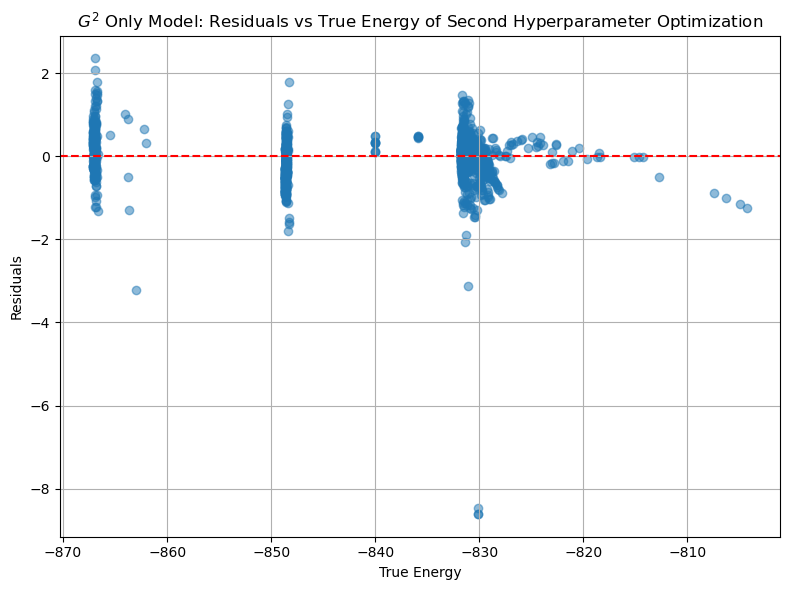

In [19]:
# Residuals

residuals = y_pred_unscaled - y_val_unscaled

plt.figure(figsize=(8, 6))
plt.scatter(y_val_unscaled, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Energy')
plt.ylabel('Residuals')
plt.title('$G^2$ Only Model: Residuals vs True Energy of Second Hyperparameter Optimization')
plt.grid(True)
plt.tight_layout()
plt.show()